In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

import neuro_morpho_toolbox as nmt
pickle_in = open("/home/penglab/FeaCal/AP_hdbscan_ns.pickle","rb")
example_ = pickle.load(pickle_in)
ns_xie = example_[0]

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.82
Loading CCF brain structure data...
Loading time: 0.00


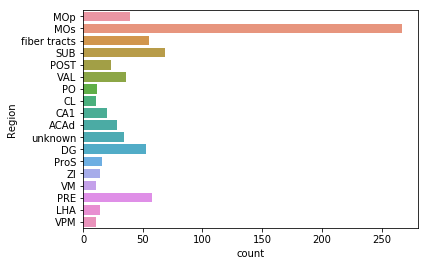

In [2]:
sf = ns_xie.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )


## function fromSOMAtoAXON() will return a dataframe 
* first a DataFrame will be generated, 

* **clusterDF** stores the information of clustering result, with columns ['swc list', 'soma region', 'max soma', 'total soma', 'max axon']


In [8]:
import ast
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def normalize(df, log=True):
    scaled_data = np.array(df) / np.sum(df, axis=0).values.reshape(-1,1) * 100000
    if log:
        scaled_data = np.log(scaled_data+100)
    scaled_dataDF = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
    return scaled_dataDF

def fromSOMAtoAXON(ns,dicF):
    somaDF = ns.features['soma_features'].region
    axonDF = ns.features['projection_features'].raw_data
    normaF=0

    somaregionDF = somaDF.copy()
    axonregionDF = axonDF.copy()      

    colname = ['Cluster Num','soma Region List','axon Region List']

    typeR, typeC = np.unique(ns.metadata['Cluster'] , return_counts = True)
    detailDF = pd.DataFrame(index = typeR,columns = ['swc list','soma region','max soma','total soma',
                                                             'max axon'])

        # for each cluster result UNDER EACH PARAMETER
    somaCLUSTERlist = []
    axonCLUSTERlist = []

    #axonCLUSTER = pd.DataFrame(index = axonregionDF.columns[:-1])
    for label_idx in detailDF.index:
        axonTEMPdf = pd.DataFrame(index = axonregionDF.columns)
        swcINlabel = ns.metadata[ns.metadata['Cluster']==label_idx]
        detailDF.loc[label_idx,'swc list'] = (swcINlabel.index).tolist()
        #assert(len(inter_list)==somaDF[somaDF['cluster'] !=label_idx].shape[0])
        detailDF.loc[label_idx,'soma region'] = swcINlabel['SomaRegion'].tolist()
        del_soma_region = detailDF.loc[label_idx,'soma region']
        while 'unknown' in del_soma_region:
            del_soma_region.remove('unknown')
            del_soma_region.append('others')
        while 'fiber tracts' in del_soma_region:
            del_soma_region.remove('fiber tracts')
            del_soma_region.append('others')
        IDrange, IDcounts = np.unique(del_soma_region, return_counts = True)
        #sort the counting
        count_sort_ind = np.argsort(-IDcounts)
        dicitem = []
        for i in range(1,min(len(IDrange)+1,4)):
            dicitem.append(str(i)+'somaR')
        for i in range(1,min(len(IDrange)+1,4)):
            dicitem.append(str(i)+'somaC')
        #select the first three regions
        dicvalue = IDrange[count_sort_ind][0:min(3,len(IDrange))]
        dicvalue = np.append(dicvalue,IDcounts[count_sort_ind][0:min(3,len(IDrange))])
        detailDF.loc[label_idx,'max soma'] = str(dict(zip(dicitem, dicvalue)))
        detailDF.loc[label_idx,'total soma'] = swcINlabel.shape[0]

        #axonLABEL stores all the rows under same cluster
        axonregionDF.loc[:,'cluster'] = ns.metadata['Cluster'].copy()
        axonLABEL = axonregionDF[axonregionDF['cluster']==label_idx].copy()
        axonLABEL.drop('cluster', axis=1,inplace=True)
        axonTEMPdf[label_idx]=axonLABEL.sum()
        if 'contra_fiber tracts' in axonTEMPdf.index:
            axonTEMPdf.drop(index=['contra_fiber tracts'],inplace = True)
        if 'ipsi_fiber tracts' in axonTEMPdf.index:
            axonTEMPdf.drop(index=['ipsi_fiber tracts'],inplace = True)
        if normaF:
            #normalize the sum
            axonTEMPdf = normalize(axonTEMPdf , log=True)
        axonTEMPdf.sort_values(by=label_idx, ascending=False, inplace=True)
        dicitem = []
        for i in range(1,5):
            dicitem.append(str(i)+'axonR')
        for i in range(1,5):
            dicitem.append(str(i)+'axonC')

        dicvalue = axonTEMPdf.index[:3]
        dicvalue = np.append(dicvalue, 'other')
        dicvalue = np.append(dicvalue,axonTEMPdf.loc[:,label_idx][:3])
        dicvalue = np.append(dicvalue,sum(axonTEMPdf.loc[:,label_idx][:-1])-sum(axonTEMPdf.loc[:,label_idx][:3]))
        detailDF.loc[label_idx,'max axon'] = str(dict(zip(dicitem, dicvalue)))
        axonCLUSTERlist.append(detailDF.loc[label_idx,'max axon'] )
    #(detailDF).to_csv('/home/penglab/Documents/detailXie.csv')
    clusterDF = detailDF.copy()
    dfname=[]
    for cluster_idx in clusterDF.index:
        dfname.append((str(cluster_idx) + 'DF'))

    #generate a dataframe for each cluster
    dicDF = {k:None for k in dfname}

    #iterate the correponding dataframe and cluster at the same time
    for key_iter,cluster_idx in zip(dicDF.keys(),clusterDF.index):
        dic_soma = ast.literal_eval(clusterDF.loc[cluster_idx,'max soma'])
        iterL = int(len(dic_soma.keys())/2)
        somaNAME = []
        somaCOUNT = []

        for i in range(1,int(iterL)+1):
            somaNAME.append(dic_soma[(str(i)+'somaR')])
        for i in range(1,iterL+1):
            somaCOUNT.append(dic_soma[str(i)+'somaC'])
        somaArr = np.array(somaCOUNT, dtype = float)
        somaArr = somaArr/sum(somaArr)
        dic_axon = ast.literal_eval(clusterDF.loc[cluster_idx,'max axon'])
        iterL = int(len(dic_axon.keys())/2)
        axonNAME = []
        axonCOUNT = []
        for i in range(1,iterL+1):
            axonNAME.append(dic_axon[(str(i)+'axonR')])
        for i in range(1,iterL+1):
            axonCOUNT.append(dic_axon[str(i)+'axonC']) 

        tempDF = pd.DataFrame()
        for row_soma in somaNAME:
            for col_axon,len_axon in zip(axonNAME,axonCOUNT):
                tempDF.loc[row_soma, col_axon] = len_axon

        assert(tempDF.shape[0] == len(somaArr))  
        tempDF=tempDF.astype(float)
        for i in range(tempDF.shape[0]):
            tempDF.iloc[i,:] = tempDF.iloc[i,:]*somaArr[i].copy()

        newDF = pd.DataFrame(columns=['from','to','value'],index=range(tempDF.shape[0]*tempDF.shape[1]))
        newDF.loc[:,'from'] = (tempDF.index).tolist()*len(tempDF.columns)
        newDF.loc[:,'to'] = [ele for ele in (tempDF.columns).tolist() for _ in range(len(tempDF.index))]
        valuelist=[]
        for iter_col in tempDF.columns:
            for iter_row in tempDF.index:
                valuelist.append(tempDF.loc[iter_row,iter_col])
        newDF.loc[:,'value']=valuelist
        dicDF[key_iter]= newDF.copy()
    if dicF:
        return dicDF
    else:
        return detailDF


In [9]:
dicXie = fromSOMAtoAXON(ns_xie,0)


In [12]:
dicXie.to_csv('/home/penglab/Documents/AP_hdbscan_detail.csv')

In [16]:
len(dicXie.loc['C3','swc list'])+len(dicXie.loc['C14','swc list'])+len(dicXie.loc['C15','swc list'])+len(dicXie.loc['C17','swc list'])+len(dicXie.loc['C19','swc list'])+len(dicXie.loc['C20','swc list'])+len(dicXie.loc['C21','swc list'])+len(dicXie.loc['C22','swc list'])+len(dicXie.loc['C23','swc list'])

212

In [5]:
for iter_key in dicXie.keys():
    tempDF = dicXie[iter_key]
    print(tempDF)
    (tempDF).to_csv('/home/penglab/Documents/UPDATExie/'+str(iter_key)+'.csv')

      from        to         value
0   others  ipsi_PAG  3.573101e+05
1      LHA  ipsi_PAG  1.128348e+05
2       ZI  ipsi_PAG  1.034319e+05
3   others  ipsi_MRN  2.999648e+05
4      LHA  ipsi_MRN  9.472573e+04
5       ZI  ipsi_MRN  8.683192e+04
6   others  ipsi_SCm  1.654967e+05
7      LHA  ipsi_SCm  5.226212e+04
8       ZI  ipsi_SCm  4.790695e+04
9   others     other  3.204511e+06
10     LHA     other  1.011951e+06
11      ZI     other  9.276216e+05
   from        to         value
0  ORBl   ipsi_CP  37965.858413
1  ORBl  ipsi_MRN   7643.265252
2  ORBl  ipsi_PAG   2340.150058
3  ORBl     other  22927.999080
      from         to          value
0   others  ipsi_VISp  332719.097625
1     VISp  ipsi_VISp  166359.548813
2     VISl  ipsi_VISp  110906.365875
3   others  ipsi_VISl  113939.099027
4     VISp  ipsi_VISl   56969.549513
5     VISl  ipsi_VISl   37979.699676
6   others  ipsi_RSPv   88443.041395
7     VISp  ipsi_RSPv   44221.520697
8     VISl  ipsi_RSPv   29481.013798
9   others     

In [6]:
dicXie

{'C1DF':       from        to         value
 0   others  ipsi_PAG  3.573101e+05
 1      LHA  ipsi_PAG  1.128348e+05
 2       ZI  ipsi_PAG  1.034319e+05
 3   others  ipsi_MRN  2.999648e+05
 4      LHA  ipsi_MRN  9.472573e+04
 5       ZI  ipsi_MRN  8.683192e+04
 6   others  ipsi_SCm  1.654967e+05
 7      LHA  ipsi_SCm  5.226212e+04
 8       ZI  ipsi_SCm  4.790695e+04
 9   others     other  3.204511e+06
 10     LHA     other  1.011951e+06
 11      ZI     other  9.276216e+05, 'C10DF':    from        to         value
 0  ORBl   ipsi_CP  37965.858413
 1  ORBl  ipsi_MRN   7643.265252
 2  ORBl  ipsi_PAG   2340.150058
 3  ORBl     other  22927.999080, 'C11DF':       from         to          value
 0   others  ipsi_VISp  332719.097625
 1     VISp  ipsi_VISp  166359.548813
 2     VISl  ipsi_VISp  110906.365875
 3   others  ipsi_VISl  113939.099027
 4     VISp  ipsi_VISl   56969.549513
 5     VISl  ipsi_VISl   37979.699676
 6   others  ipsi_RSPv   88443.041395
 7     VISp  ipsi_RSPv   44221.520697